
<center>

# Natural language processing
## Project - Sentence segmentation
## Data Preparation

### 2023./2024.
## Matea Kunac, Marijana Rendulić
</center>

# 1. Introduction

This notebook focuses on the data preparation and descriptive statistics for the HR500k 2.0 dataset, aimed at sentence segmentation. We will load the dataset, analyze its structure, and perform initial preprocessing steps to prepare for model training.

# 2. Dataset loading

##HR500k dataset

The hr500k training corpus contains about 500,000 tokens manually annotated on the levels of
tokenisation, sentence segmentation, morphosyntactic tagging, lemmatisation and named entities. About half of the corpus is also manually annotated with syntactic dependencies. A subset of the syntactically annotated corpus is also annotated for multi-word expressions. Furthermore, about a fifth of the corpus is annotated with semantic role labels.

##Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
nltk.download('punkt')
import pandas as pd
import pickle
from collections import Counter
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.nn.utils.rnn import pad_sequence
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Dataset files

- Dev - for evaluation
- Train - for training
- Test - for testing

In [3]:
# Dataset file paths
dataset_files = {
    'dev': '/content/drive/MyDrive/Sentence_segmentation_popravak/data/hr500k-dev.conllu',
    'train': '/content/drive/MyDrive/Sentence_segmentation_popravak/data/hr500k-train.conllu',
    'test': '/content/drive/MyDrive/Sentence_segmentation_popravak/data/hr500k-test.conllu'
}

#3. Descriptive statistics

In [4]:
def get_sentences_stats(sentences):
    """
    Returns statistics for a list of sentences: total number of sentences, total number of words,
    vocabulary size, average sentence length, maximum sentence length, and minimum sentence length.
    """
    total_sentences = len(sentences)
    all_words = [word for sentence in sentences for word in word_tokenize(sentence.lower())]
    total_words = len(all_words)
    unique_words = len(set(all_words))
    average_sentence_length = total_words / total_sentences
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    max_sentence_length = max(sentence_lengths)
    min_sentence_length = min(sentence_lengths)

    stats = {
        'total_sentences': total_sentences,
        'total_words': total_words,
        'unique_words': unique_words,
        'average_sentence_length': average_sentence_length,
        'max_sentence_length': max_sentence_length,
        'min_sentence_length': min_sentence_length
    }

    return stats

In [5]:
def plot_sentence_length_distribution(sentence_lengths):
    """
    Plots the distribution of sentence lengths.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(sentence_lengths, bins=30, edgecolor='k')
    plt.title('Distribution of Sentence Lengths')
    plt.xlabel('Sentence Length (number of words)')
    plt.ylabel('Frequency')
    plt.show()

In [6]:
def print_stats(stats):
    """
    Prints the descriptive statistics.
    """
    print(f"Total number of sentences: {stats['total_sentences']}")
    print(f"Total number of words: {stats['total_words']}")
    print(f"Vocabulary size: {stats['unique_words']}")
    print(f"Average sentence length: {stats['average_sentence_length']:.2f} words")
    print(f"Max sentence length: {stats['max_sentence_length']} words")
    print(f"Min sentence length: {stats['min_sentence_length']} words")

In [7]:
def load_sentences(file_path):
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('# text = '):
                sentences.append(line[len('# text = '):].strip())
    return sentences


Descriptive Statistics for DEV Dataset:
Total number of sentences: 2486
Total number of words: 49764
Vocabulary size: 14139
Average sentence length: 20.02 words
Max sentence length: 98 words
Min sentence length: 1 words


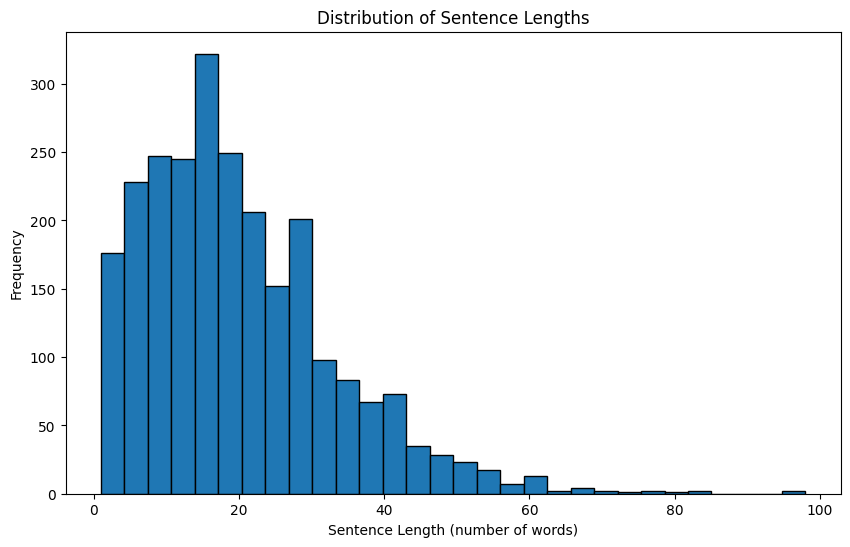


Descriptive Statistics for TRAIN Dataset:
Total number of sentences: 19791
Total number of words: 398932
Vocabulary size: 58374
Average sentence length: 20.16 words
Max sentence length: 255 words
Min sentence length: 1 words


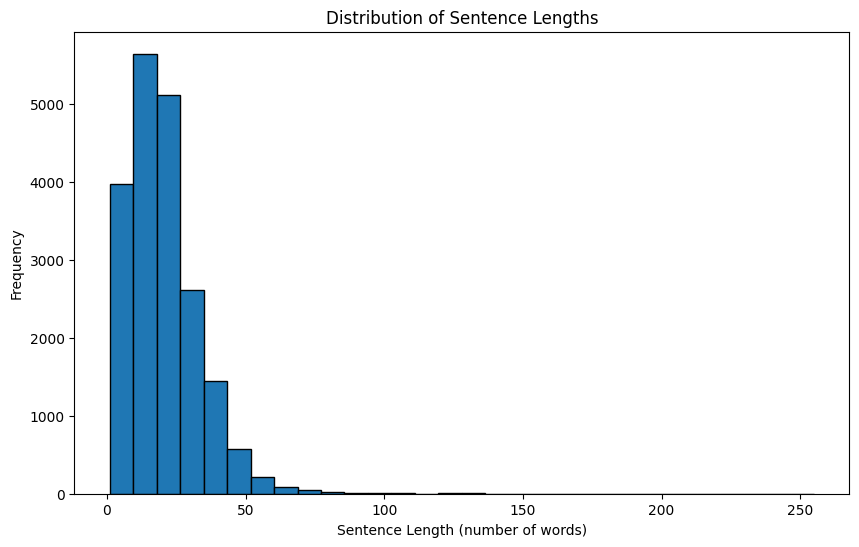


Descriptive Statistics for TEST Dataset:
Total number of sentences: 2486
Total number of words: 51236
Vocabulary size: 14560
Average sentence length: 20.61 words
Max sentence length: 142 words
Min sentence length: 1 words


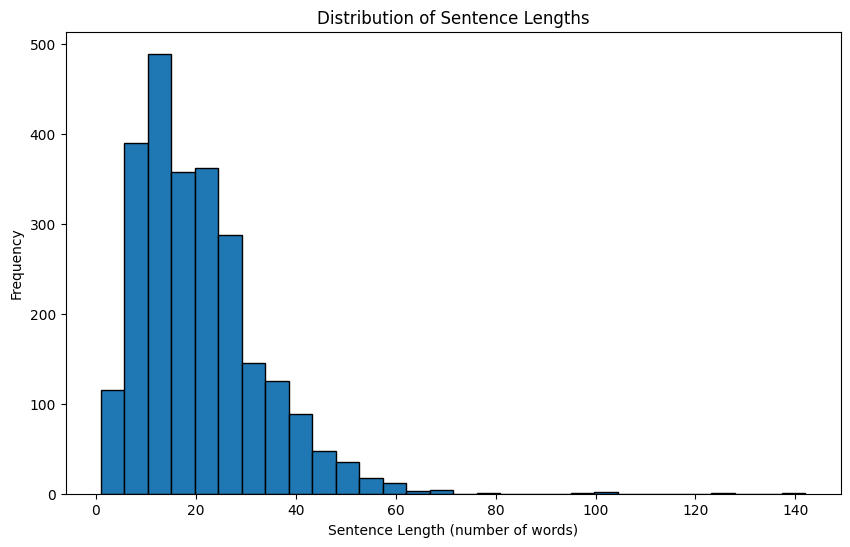

In [8]:
for subset, path in dataset_files.items():
    sentences = load_sentences(path)
    stats = get_sentences_stats(sentences)
    print(f"\nDescriptive Statistics for {subset.upper()} Dataset:")
    print_stats(stats)
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    plot_sentence_length_distribution(sentence_lengths)

#4.Data preparation

In [9]:
def preprocess_and_encode(sentences, max_length):
    """
    Tokenize sentences and concatenate them into chunks with labels.
    Sentences: List of sentences.
    Max_length: Maximum length of each chunk.
    """
    all_chunks = []
    all_labels = []
    current_chunk = []
    current_labels = []

    for sentence in sentences:
        tokens = word_tokenize(sentence.lower())
        labels = [1] + [0] * (len(tokens) - 1)

        if len(current_chunk) + len(tokens) <= max_length:
            current_chunk.extend(tokens)
            current_labels.extend(labels)
        else:
            all_chunks.append(current_chunk)
            all_labels.append(current_labels)
            current_chunk = tokens
            current_labels = labels

    if current_chunk:
        all_chunks.append(current_chunk)
        all_labels.append(current_labels)

    return all_chunks, all_labels

In [10]:
def build_vocab(chunks):
    """
    Takes a list of text chunks (where each chunk is a list of tokens) and builds a vocabulary
    """
    token_counts = Counter(token for chunk in chunks for token in chunk)
    vocab = {word: i+1 for i, (word, _) in enumerate(token_counts.items())}
    return vocab

In [11]:
def encode_chunks_and_labels(chunks, labels, vocab):
    """
    Given the chunks of tokens, their corresponding labels, and the vocabulary,
    this function encodes the chunks by replacing each token with its integer index from the vocabulary.
    """
    encoded_chunks = [[vocab.get(token, 0) for token in chunk] for chunk in chunks]
    return encoded_chunks, labels

In [12]:
def save_data(encoded_chunks, encoded_labels, vocab, directory, prefix):
    """
    Saves the encoded chunks, encoded labels, and the vocabulary to files in a specified directory.
    """
    with open(os.path.join(directory, f'{prefix}_encoded_chunks.pkl'), 'wb') as f:
        pickle.dump(encoded_chunks, f)
    with open(os.path.join(directory, f'{prefix}_encoded_labels.pkl'), 'wb') as f:
        pickle.dump(encoded_labels, f)
    with open(os.path.join(directory, 'vocab.pkl'), 'wb') as f:
        pickle.dump(vocab, f)

In [13]:
sentences = load_sentences(dataset_files['train'])
max_length = 100
chunks, labels = preprocess_and_encode(sentences, max_length)
vocab = build_vocab(chunks)
encoded_chunks, encoded_labels = encode_chunks_and_labels(chunks, labels, vocab)
data_directory = '/content/drive/MyDrive/Sentence_segmentation_popravak/data'
save_data(encoded_chunks, encoded_labels, vocab, data_directory, 'train')

In [14]:
def prepare_and_save_dataset(file_path, vocab, data_directory, prefix):
    """
    Loads sentences from a file, preprocessing them,
    encoding them using a given vocabulary, and finally saving the encoded data and vocabulary.
    """
    sentences = load_sentences(file_path)
    chunks, labels = preprocess_and_encode(sentences, max_length=100)  # Use the same max_length as for the training set
    encoded_chunks, encoded_labels = encode_chunks_and_labels(chunks, labels, vocab)
    save_data(encoded_chunks, encoded_labels, vocab, data_directory, prefix)

# Prepare and save dev data
prepare_and_save_dataset(dataset_files['dev'], vocab, data_directory, 'dev')

# Prepare and save test data
prepare_and_save_dataset(dataset_files['test'], vocab, data_directory, 'test')

In [15]:
def print_chunks_and_labels(encoded_chunks, encoded_labels, rev_vocab, num_samples=5):
    """
    Prints a specified number of text chunks and their corresponding labels.
    """
    for i in range(min(num_samples, len(encoded_chunks))):
        chunk = encoded_chunks[i]
        labels = encoded_labels[i]
        words = [rev_vocab[id] for id in chunk]
        text = ' '.join(words)
        print(f"Chunk {i+1}:")
        print(text)
        print("Labels:")
        print(labels)
        print("\n")

In [16]:
def reverse_vocab(vocab):
    """
    Creates a reverse mapping from numerical IDs back to words.
    """
    return {id: word for word, id in vocab.items()}

rev_vocab = reverse_vocab(vocab)

print_chunks_and_labels(encoded_chunks, encoded_labels, rev_vocab, num_samples=5)

Chunk 1:
kazna medijskom mogulu obnovila raspravu u makedoniji neki tvrde da je presuda veliji ramkovskom napad na slobodu medija , dok drugi tvrde kako dokazi o njegovim kaznenim djelima govore suprotno . medijski mogul velija ramkovski osuđen je na 13 godina zatvora zbog utaje poreza i pranja novca . kaznena presuda i zatvorska kazna medijskom mogulu veliji ramkovskom , koji je često kritizirao makedonsku vladu , mogla bi zaplašiti medije , kažu novinari u toj maloj balkanskoj državi .
Labels:
[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Chunk 2:
ramkovski , bivši vlasnik televizijske postaje a1 , četiriju novina i drugih poduzeća , osuđen je na kaznenom sudu u skoplju 14. ožujka na 13 godina zatvora zbog pranja novca , kriminalne zavjere , zloporabe položaja i utaje poreza ; 19 suučesnika dobil